# 4- Exploration and importance of features

Here we will try several combinations in order to form a network composed of nodes and edges. We will take different assumptions to choose our nodes and edges and will try to compare each configuration in order to elect the one we will keep for the rest of the project.

First we import the packages we will need : 

In [1]:
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
plt.rcdefaults()

In [2]:
pd_data =pd.read_csv('./data/steam_clean.csv')
pd_data.head()

,appid,name,release_date,english,french,german,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success
0,340,Half-Life 2: Lost Coast,2005-10-27,1,1,1,Valve,Valve,windows;mac;linux,0,Single-player;Commentary available;Remote Play...,Action,FPS;Action;Singleplayer,0,6412,1072,123,23,2000000-5000000,0.0,0.0
1,440,Team Fortress 2,2007-10-10,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Cross-Platform Multiplayer;Steam ...,Action;Free to Play,Hero Shooter;Free to Play;Multiplayer,520,588020,37107,8895,452,50000000-100000000,0.0,0.0
2,570,Dota 2,2013-07-09,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Multiplayer,0,1018172,174020,29989,1284,100000000-200000000,0.0,0.0
3,630,Alien Swarm,2010-07-19,1,0,0,Valve,Valve,windows,0,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Free to Play;Co-op;Action,66,17946,974,319,96,1000000-2000000,0.0,0.0
4,730,Counter-Strike: Global Offensive,2012-08-21,1,1,1,Valve;Hidden Path Entertainment,Valve,windows;mac;linux,0,Multi-player;Steam Achievements;Full controlle...,Action;Free to Play,FPS;Shooter;Multiplayer,167,3295593,470639,25886,7129,20000000-50000000,0.0,0.0


In [3]:
len(pd_data.owners)

29380

# Cleaning

As we are studying a game success, we will remove of the analysis all the games that are a complete failure, thus having less than or exactly 20'000 owners. This number has been chosen as the mean number of owners is ## to complete ##. As of right now, the number of owners are a string giving a range of number of owners. For pratical issues we will take the middle of the range as the value of number of owners for each game. 

In [4]:
type(pd_data.owners[1])

str

In [5]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def remove_non_language(df):
    # keep only rows marked as supporting english
    df = df[df['english'] ==1 ].copy()
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove english column, now redundant
    df = df.drop(['english', 'french','german'], axis=1)
    
    return df

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # only going to use these categories (can uncomment to use others)
    cat_cols = [
         'Local Multi-Player',
         'MMO',
        # 'Mods',
        'Multi-player',
         'Online Co-op',
         'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])
    
    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
         'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


def pre_process(pd_data):
    """Preprocess Steam dataset for exploratory analysis."""
    df = pd_data.copy()#pd.read_csv('./data/steam_clean.csv')
    
    # keep english only
    df = remove_non_language(df)
    
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    
    # only keep games playable on PC 
    #df['platforms'] = df['platforms'].str.split(';').apply(lambda x: x[0])
    
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    df['release_month'] = df['release_date'].apply(lambda x: x.month)
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    # remove average_playtime as deemed not relevant for our analysis in the way it is calculated
    df = df.drop(columns=['average_playtime','median_playtime'])

    return df

data = pre_process(pd_data)
print('Verify no missing values:')
print(data.isnull().sum().value_counts())

data.head()


Verify no missing values:
0    33
1     1
dtype: int64


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategyviolent
0,340,Half-Life 2: Lost Coast,2005-10-27,Valve,Valve,0,Action,0,6412,1072,2000000,0.0,0.0,7484,0.856761,82.754771,2005,10,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,440,Team Fortress 2,2007-10-10,Valve,Valve,0,Action;Free to Play,520,588020,37107,50000000,0.0,0.0,625127,0.940641,93.217574,2007,10,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,570,Dota 2,2013-07-09,Valve,Valve,0,Action;Free to Play;Strategy,0,1018172,174020,100000000,0.0,0.0,1192192,0.854034,84.770535,2013,7,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,630,Alien Swarm,2010-07-19,Valve,Valve,0,Action,66,17946,974,1000000,0.0,0.0,18920,0.948520,92.405605,2010,7,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
4,730,Counter-Strike: Global Offensive,2012-08-21,Valve;Hidden Path Entertainment,Valve,0,Action;Free to Play,167,3295593,470639,20000000,0.0,0.0,3766232,0.875037,87.045099,2012,8,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


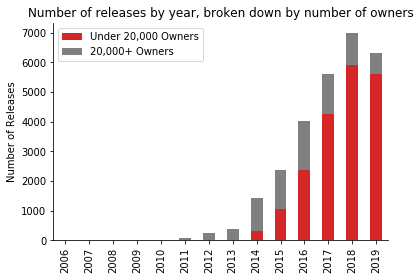

In [6]:
df = data.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2019:
        # very few releases in data prior to 2006, and we're still in 2019 (at time of writing)
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'gray'])

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

The chart above shows the total number of releases by year in the dataset, and breaks these totals down by those games with less than 20,000 owners (in red), and those with 20,000 owners or more. Bear in mind that games with over 20,000 owners includes games with owners into the millions, so it's a very broad range.

By looking at this chart we can clearly see that, since 2014:
- The number of releases for games having 20,000 or more owners has remained relatively constant, seen by the sizes of the gray bars, at around 1,000 to 2,000 releases per year
- The number of releases with fewer than 20,000 owners has skyrocketed in this same period, seen by the sizes of the red bars, from maybe 250 in 2014 to nearly 7,000 in 2018

Of course games released more recently won't have had the same amount of time to generate sales as games released a long time ago, but I don't think this accounts for the pattern we see here. A couple of likely reasons may be that [Steam Greenlight opened in August 2012](https://store.steampowered.com/news/8761/), and following the closure of Greenlight, [Steam Direct opened in June 2017](https://steamcommunity.com/games/593110/announcements/detail/1328973169870947116). Both of these platforms allowed increasingly easier access for releasing games onto the Steam Store, allowing smaller independent titles to be listed, causing an explosion of releases that would otherwise have had to rely on other stores. Another reason is the [growth in the gaming industry](https://en.wikipedia.org/wiki/Video_game_industry#Economics), especially in mobile games which tend to be smaller, lighter games which are sometimes ported onto computers and the Steam Store.

My interpretation therefore is that the Steam store has been somewhat flooded with smaller releases and, in some cases, lower-quality releases - with games added to the Steam platform to try and tap into that market rather than being specifically developed for it - suggesting the vast majority can be set aside. We may lose some insight if we choose to remove these games, but I think we'll be able to gain more valuable information by focusing only on releases with 20,000 owners or more.

In [7]:
dfa = df[df.owners >= 20000].copy()

In [8]:
dfa = dfa.drop(columns=['developer','release_date','required_age', 'achievements','positive_ratings','negative_ratings'])
dfa = dfa.dropna()

In [9]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0, dim = True ):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    
    if(dim):
        sq_dist = pdist(X)
    else:
        sq_dist = X
        
    pairwise_dists = squareform(sq_dist)**2
    adjacency = np.exp( -pairwise_dists / (2*sigma**2) - np.identity(len(pairwise_dists)))

    threshold = adjacency < epsilon

    adjacency[threshold]=0
    
    return adjacency

Now we normalize the number of owners to millions as well as the economic success in millions

In [10]:
dfa['owners'][0]

2000000

In [11]:
pd_data = dfa.copy()
pd_data['owners'] =  np.log(dfa['owners'])# /10**6
pd_data['economic_success'] = np.log(pd_data['economic_success']+1)#/10**6

In [12]:
pd_data.head()

,appid,name,publisher,genres,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategyviolent
0,340,Half-Life 2: Lost Coast,Valve,Action,14.508658,0.0,0.0,7484,0.856761,82.754771,2005,10,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,440,Team Fortress 2,Valve,Action;Free to Play,17.727534,0.0,0.0,625127,0.940641,93.217574,2007,10,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,570,Dota 2,Valve,Action;Free to Play;Strategy,18.420681,0.0,0.0,1192192,0.854034,84.770535,2013,7,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,630,Alien Swarm,Valve,Action,13.815511,0.0,0.0,18920,0.948520,92.405605,2010,7,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
4,730,Counter-Strike: Global Offensive,Valve,Action;Free to Play,16.811243,0.0,0.0,3766232,0.875037,87.045099,2012,8,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


# Final Dataset after cleaning

Our final dataset consists of a dataset containing the following features : 
- Language of the game
- Publisher of the game
- Platform of the game 
- Genre of the game 
- Average playtime of the game
- Median playtime of the game
- Number of owners of the game
- Release year of the game
- Release month of the game

Each game is identified by : 
- Its full name
- Its Steam identification number

To characterize the success of our game, we introduced two metrics : 
- The economic success 
- The Steam grade

In [13]:
#output_path = "./cleaned_data.csv"
#pd_data.to_csv(output_path)

## Machine Learning on features

We can drop some useless features for the machine learning algorithm

In [14]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [15]:
ml_data = pd_data.copy()
ml_data = pd_data.drop(columns = ['name','release_year','publisher','genres'])
ml_data

,appid,owners,price,economic_success,total_ratings,rating_ratio,rating,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategyviolent
0,340,14.508658,0.00,0.000000,7484,0.856761,82.754771,10,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,440,17.727534,0.00,0.000000,625127,0.940641,93.217574,10,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,570,18.420681,0.00,0.000000,1192192,0.854034,84.770535,7,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,630,13.815511,0.00,0.000000,18920,0.948520,92.405605,7,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
4,730,16.811243,0.00,0.000000,3766232,0.875037,87.045099,8,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
6,3483,12.206073,0.00,0.000000,852,0.929577,86.863051,9,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
8,6370,13.122363,0.00,0.000000,1608,0.858831,81.231423,10,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0
9,8310,9.903488,0.00,0.000000,158,0.525316,46.820747,6,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
10,8320,10.819778,0.00,0.000000,87,0.586207,51.005630,6,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
11,8500,14.508658,0.00,0.000000,14886,0.761991,74.086696,12,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0


In [16]:
num_ml_data = ml_data[ml_data.select_dtypes(include = ['int32','int64','float64']).columns]

In [17]:
target_ml_data = ml_data[['economic_success','rating']]
features_ml_data = ml_data.drop(columns = ['economic_success','rating'])

We split the dataset

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_ml_data, target_ml_data, test_size=0.2, random_state=1, shuffle=True)

In [19]:
def plot_validation_curve(train_scores,cv_scores,x_data,scale='lin',title='',y_label='',x_label=''):

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    lw = 2

    plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
    plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)

    if (scale == 'lin'):
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    elif (scale == 'log'):
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

For feature selection, we will be using the Lasso regression that allows us to obtain the subset of features that minimize the prediction error for a quantitative response variable, in our case, the Steam grade.

In [20]:
lasso_pipeline = make_pipeline(StandardScaler(), Lasso())
cv_schema = StratifiedKFold(n_splits = 5, random_state = 1)
MSE = make_scorer(mean_squared_error)

In [21]:
pd_data.name[9]

'Bone: Out From Boneville'

# Not functional for new, let's try another method tomorrow

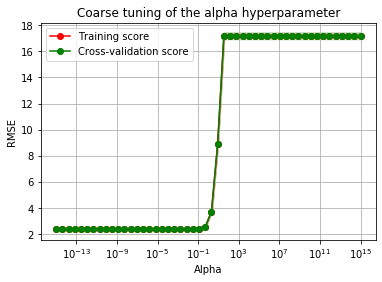

In [22]:
alpha_range = np.logspace(-15, 15, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['rating'], param_name="lasso__alpha",
                                                       param_range=alpha_range, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l),np.sqrt(cv_scores_val_l), alpha_range,
                      'log','Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

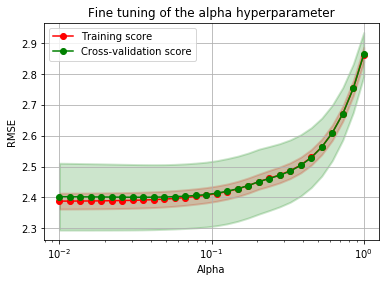

In [23]:
alpha_range_fine = np.logspace(-2, 0, 30)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['rating'], param_name="lasso__alpha",
                                                       param_range=alpha_range_fine, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [24]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['rating'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_rating = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
lasso_regr_rating

array([6.62562256e-02, 1.90102855e+00, 7.73027968e-01, 4.43404650e-02,
       1.64527710e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.12485419e-02, 4.53042653e-02, 0.00000000e+00, 4.43750737e-02,
       0.00000000e+00, 4.50165953e-02, 1.59222084e-01, 2.53886366e-01,
       1.15860938e-03, 9.91613392e-02, 0.00000000e+00, 1.90600529e-01,
       0.00000000e+00, 0.00000000e+00])

In [25]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
optimal_alpha_l

0.035622478902624426

In [26]:
feature_zero_steam = X_train.columns[np.where(lasso_regr_rating == 0)[0]]
set_non_zero_features_steam = set(X_train.columns[np.where(lasso_regr_rating != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_rating = X_train.columns[np.argsort(lasso_regr_rating)][::-1][1:5]

In [27]:
feature_rating

Index(['owners', 'price', 'indie', 'simulation'], dtype='object')

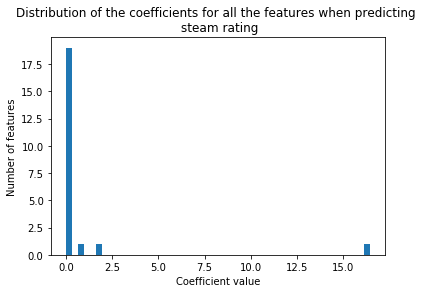

In [28]:
plt.figure(1)
plt.hist(np.abs(lasso_regr_rating),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n steam rating')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

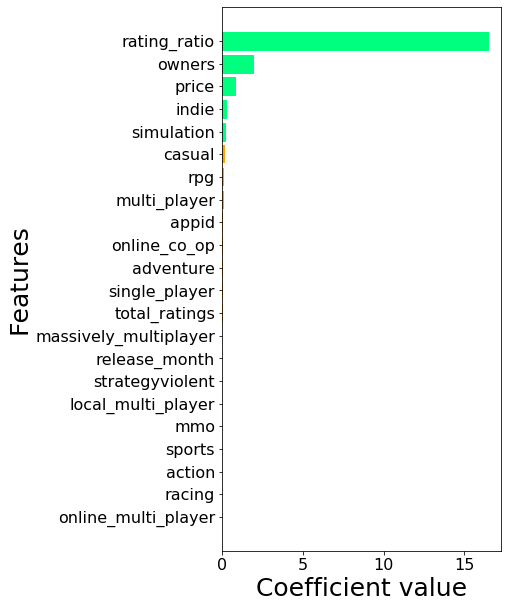

In [29]:
lasso_rating_df = pd.DataFrame([lasso_regr_rating, X_train.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))

plt.rcParams.update({'font.size': 16})

barlist = plt.barh(lasso_rating_df.features, lasso_rating_df.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/rating_feat.png', bbox_inches="tight")
plt.show()